 ## Defining the problem and assembling a dataset

- Tensorflow Imagenette Dataset
  - https://www.tensorflow.org/datasets/catalog/imagenette
- Multi-Class Classification Problem

 ## Choosing a measure of success

- Accuracy Score
- Precision and Recall
- AUC

## Deciding on an evaluation protocol

- Maintaining a hold-out validation and test sets
- Doing K-fold cross-validation

## Preparing your data

In [152]:
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from skimage.color import rgb2gray
from skimage.transform import resize

import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop

import itertools
import matplotlib.pyplot as plt

SEED = 204

tf.random.set_seed(SEED)
np.random.seed(SEED)

import warnings
warnings.filterwarnings('ignore')

In [280]:
DATASET = 'imagenette/160px'
RESIZE = (64, 64, 3)
GRAY_SCALE = True

In [281]:
ds = tfds.load(DATASET, split='all', shuffle_files=True)

images, labels = [], []
for entry in ds.take(len(ds)) :
    image, label = entry['image'], entry['label']
    
    image, label = image.numpy(), label.numpy()
    
    image = resize(image, RESIZE, anti_aliasing=True)
            
    if GRAY_SCALE :
        image = rgb2gray(image)
        
    images.append( image )
    labels.append( label )

In [86]:
# list of images to numpy array
X = np.array(images)

# flatten 2D image array to 1D array
X = X.reshape( (X.shape[0], -1) )

In [87]:
label_encoder = LabelEncoder()
label_encoder.fit(labels)

# label -> one-hot encoded vector
y = np_utils.to_categorical(label_encoder.transform(labels))

In [88]:
TEST_SIZE = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=labels, 
                                                    random_state=SEED, shuffle=True)

In [89]:
# normalise pixels from [0, 255] to [0, 1]
X_train, X_test = X_train/255, X_test/255

In [90]:
VALIDATION_SIZE = X_test.shape[0]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                 test_size=VALIDATION_SIZE, stratify=y_train.argmax(axis=1),
                                                 shuffle=True, random_state=SEED)

##  Developing a model that does better than a baseline

In [93]:
# number of samples per each class
counts = np.sum(y, axis=0)

# the dataset is balanced. one class is slightly less than the others, but minimal.
counts

array([1350., 1350., 1350., 1244., 1350., 1350., 1350., 1350., 1350.,
       1350.], dtype=float32)

In [94]:
baseline = max(counts) / sum(counts)

baseline

0.10079139913394057

In [95]:
# MLP Model Instatiation
def deep_neural_network(hidden_layers=0, hidden_neurons=np.nan, activation=None,
                        dropout=np.nan, input_dimension=2, output_dimension=1,
                        optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'],
                        name=None) :
    
    model = Sequential()
    for layer in range(hidden_layers) :
        model.add(Dense(hidden_neurons, 
                  activation=activation, 
                  input_shape='default' if layer>1 else (input_dimension,)))
        if ~np.isnan(dropout) :
            model.add(Dropout(dropout))
        
    model.add(Dense(output_dimension, 
                    activation='sigmoid' if output_dimension==1 else 'softmax',
                    input_shape='default' if hidden_layers>0 else (input_dimension,)))
  
    if name is not None :
        model._name = name
        
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

In [105]:
# Fitting MLP Classification Model
def train_deep_neural_network(model, X, y,
                              batch_size=32, epochs=100, 
                              val_data=None, callbacks=[], seed=0) :
    
    if val_data is None :
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                          random_state=seed, shuffle=True, 
                                                          stratify=y)
        
    else :
        X_train, y_train, X_val, y_val = X, y, val_data[0], val_data[1]
  

    history = model.fit(X_train, y_train,
                        batch_size=batch_size, epochs=epochs, 
                        validation_data=(X_val, y_val),
                        callbacks=callbacks,
                        verbose=0)

    return {'model': model, 
            'val_score': model.evaluate(X_val, y_val, verbose=0)[1:], 
            'history': history }

In [106]:
INPUT_DIMENSION = X_train.shape[1]
OUTPUT_CLASSES = y_train.shape[1]

OPTIMIZER = 'RMSprop'
LOSS_FUNC = 'categorical_crossentropy'
METRICS = ['categorical_accuracy', 
           tf.keras.metrics.Precision(name='precision'), 
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc', multi_label=True)]

In [153]:
learning_rate = 0.1

slp_model = deep_neural_network(hidden_layers=0,
                                input_dimension=INPUT_DIMENSION, output_dimension=OUTPUT_CLASSES,
                                optimizer=RMSprop(learning_rate=learning_rate), 
                                metrics=METRICS,
                                name='Single_Layer_Perceptron')

slp_model.summary()

Model: "Single_Layer_Perceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 10)                40970     
                                                                 
Total params: 40,970
Trainable params: 40,970
Non-trainable params: 0
_________________________________________________________________


In [205]:
batch_size = 128
EPOCHS = 300

MONITOR = 'val_loss'
PATIENCE = 10

EARLY_STOP = EarlyStopping(monitor=MONITOR, restore_best_weights=True, patience=PATIENCE, verbose=0)

In [155]:
trained_slp_model = train_deep_neural_network(slp_model, X_train, y_train,
                                              batch_size=batch_size, epochs=EPOCHS, 
                                              val_data=(X_val, y_val), 
                                              callbacks=[EARLY_STOP], seed=SEED)

In [156]:
print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(trained_slp_model['val_score'][0], baseline))
print('Precision (Validation): {:.2f}'.format(trained_slp_model['val_score'][1]))
print('Recall (Validation): {:.2f}'.format(trained_slp_model['val_score'][2]))
print('AUC (Validation): {:.2f}'.format(trained_slp_model['val_score'][3]))

Accuracy (Validation): 0.31 (baseline=0.10)
Precision (Validation): 0.65
Recall (Validation): 0.04
AUC (Validation): 0.74


In [157]:
def plot_training_history(history, monitors=['loss', 'AUC']) :

  # using the variable axs for multiple Axes
  fig, axs = plt.subplots(1, 2, sharex='all', figsize=(15,5))
 
  for ax, monitor in zip(axs.flat, monitors) :
    loss, val_loss = history.history[monitor], history.history['val_' + monitor]

    if monitor == 'loss' :
      monitor = monitor.capitalize()

    epochs = range(1, len(loss)+1)

    ax.plot(epochs, loss, 'b.', label=monitor)
    ax.plot(epochs, val_loss, 'r.', label='Validation ' + monitor)
    ax.set_xlim([0, len(loss)])
    ax.title.set_text('Training and Validation ' + monitor + 's')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(monitor)
    ax.legend()
    ax.grid()

  _ = plt.show()

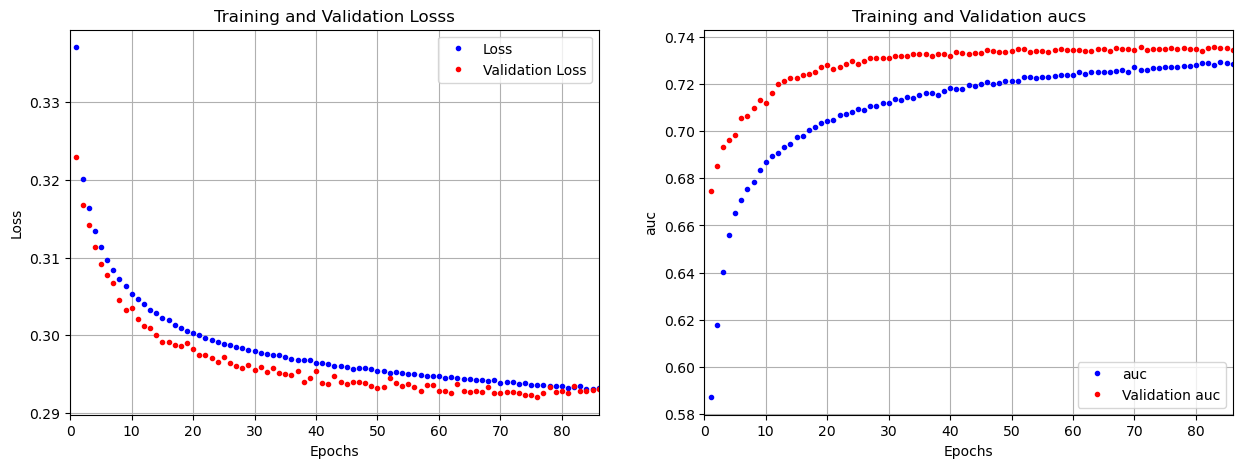

In [158]:
plot_training_history(trained_slp_model['history'], monitors=['loss', 'auc'])

 ## Scaling up: developing a model that overfits

In [206]:
learning_rate = 0.0025

mlp_model = deep_neural_network(hidden_layers=1, hidden_neurons=32,
                                activation='relu',
                                input_dimension=INPUT_DIMENSION, output_dimension=OUTPUT_CLASSES,
                                optimizer=RMSprop(learning_rate=learning_rate), 
                                loss=LOSS_FUNC, metrics=METRICS,
                                name='Multi_Layer_Perceptron')

mlp_model.summary()

Model: "Multi_Layer_Perceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 32)                131104    
                                                                 
 dense_37 (Dense)            (None, 10)                330       
                                                                 
Total params: 131,434
Trainable params: 131,434
Non-trainable params: 0
_________________________________________________________________


In [207]:
trained_mlp_model = train_deep_neural_network(mlp_model, X_train, y_train,
                                              batch_size=batch_size, epochs=EPOCHS, 
                                              val_data=(X_val, y_val), 
                                              callbacks=[], seed=SEED)

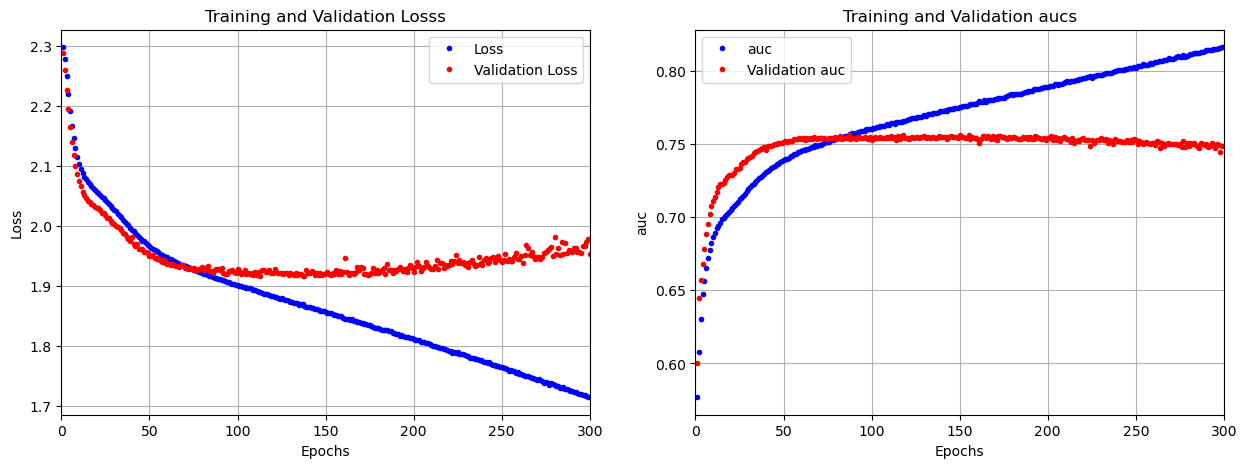

In [208]:
plot_training_history(trained_mlp_model['history'], monitors=['loss', 'auc'])

In [209]:
print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(trained_mlp_model['val_score'][0], baseline))
print('Precision (Validation): {:.2f}'.format(trained_mlp_model['val_score'][1]))
print('Recall (Validation): {:.2f}'.format(trained_mlp_model['val_score'][2]))
print('AUC (Validation): {:.2f}'.format(trained_mlp_model['val_score'][3]))

Accuracy (Validation): 0.34 (baseline=0.10)
Precision (Validation): 0.67
Recall (Validation): 0.11
AUC (Validation): 0.75


 ## Regularizing your model and tuning your hyperparameters

In [220]:
# Reformat Grid CV Stats to Dataframe
def to_dataframe(stats, mapping) :
    entries = []
    for param, metrics in stats.items() :
        entry = eval(param)
        for key, value in metrics.items() :
            entry[key] = value
        
        for key, value in mapping.items() :
            entry[value] = entry['scores'][key]
            
        entry.pop('scores') 
        
        entries.append( entry )

    return pd.DataFrame(data=entries)

In [221]:
# Grid Search CV
def grid_search_cv(X, y,
                   space, cv, 
                   learning_rate, loss, metrics, 
                   epochs, callbacks=[], seed=0, 
                   order={}) :
    
    keys, values = zip(*space.items())
    
    stats = {}
    for params in [dict(zip(keys, v)) for v in itertools.product(*values)] :
        kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=seed)
        
        scores, stopped, losses = [], [], []
        for train, validate in kfold.split(X, y.argmax(axis=1)) :
            model = deep_neural_network(hidden_layers=params['hidden_layers'], 
                                        hidden_neurons=params['neurons'], 
                                        activation=params['activation'], 
                                        dropout=params['dropout'], 
                                        input_dimension=X.shape[1], 
                                        output_dimension=1 if len(y.shape)<2 else y.shape[1],
                                        optimizer=RMSprop(learning_rate=learning_rate), 
                                        loss=loss, metrics=metrics)
      
            trained = train_deep_neural_network(model, 
                                                X[train,:], y[train], 
                                                batch_size=params['batch_size'], epochs=epochs, 
                                                val_data=(X[validate,:], y[validate,:]), 
                                                callbacks=callbacks, seed=seed) 
            
            evaluations = trained['model'].evaluate(X[validate,:], y[validate,:], verbose=0)[1:]
                        
            scores.append( evaluations )
            stopped.append( len(trained['history'].history['val_loss']) )
            losses.append( np.min(trained['history'].history['val_loss']) )
        
        stats[str(params)] = { 'scores': np.mean(scores, axis=0), 
                               'epochs': np.mean(stopped), 
                               'val_loss': np.mean(losses) }
    
    return to_dataframe(stats, order)

In [222]:
orders = {
    0: 'categorical_accuracy',              
    1: 'precision',
    2: 'recall',
    3: 'auc',
}

In [223]:
KFOLDS = 5

In [224]:
params = {
    'hidden_layers': [1],
    'neurons': [16, 32, 64],
    'activation': ['relu'],
    'dropout': [0.2],
    'batch_size': [128]
}

learning_rate = 0.0025

stats = grid_search_cv(X_train, y_train,  
                       space=params, cv=KFOLDS, 
                       learning_rate=learning_rate, 
                       loss=LOSS_FUNC, metrics=METRICS, 
                       epochs=EPOCHS, callbacks=[EARLY_STOP], seed=SEED,
                       order=orders)

In [225]:
stats.sort_values(by=['auc'], ascending=False)

,hidden_layers,neurons,activation,dropout,batch_size,epochs,val_loss,categorical_accuracy,precision,recall,auc
2,1,64,relu,0.2,128,129.4,1.933959,0.323221,0.681464,0.071401,0.748485
1,1,32,relu,0.2,128,138.0,1.962195,0.313327,0.695874,0.055908,0.739426
0,1,16,relu,0.2,128,116.8,2.004174,0.294942,0.690630,0.033695,0.724643


In [226]:
learning_rate = 0.0025

opt_model = deep_neural_network(hidden_layers=1, hidden_neurons=64,
                                dropout=0.2, activation='relu',
                                input_dimension=INPUT_DIMENSION, output_dimension=OUTPUT_CLASSES,
                                optimizer=RMSprop(learning_rate=learning_rate), 
                                loss=LOSS_FUNC, metrics=METRICS,
                                name='Deep_Wide_Network')

opt_model.summary()

Model: "Deep_Wide_Network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_102 (Dense)           (None, 64)                262208    
                                                                 
 dropout_32 (Dropout)        (None, 64)                0         
                                                                 
 dense_103 (Dense)           (None, 10)                650       
                                                                 
Total params: 262,858
Trainable params: 262,858
Non-trainable params: 0
_________________________________________________________________


In [227]:
trained_opt_model = train_deep_neural_network(opt_model, X_train, y_train,
                                              batch_size=batch_size, epochs=EPOCHS, 
                                              val_data=(X_val, y_val), 
                                              callbacks=[EARLY_STOP], seed=SEED)

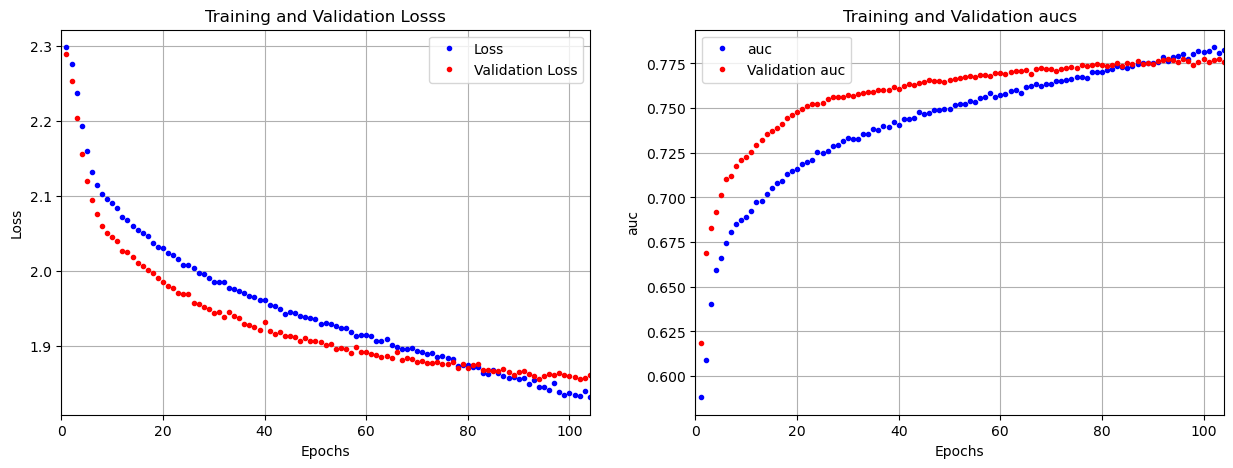

In [228]:
plot_training_history(trained_opt_model['history'], monitors=['loss', 'auc'])

In [229]:
print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(trained_opt_model['val_score'][0], baseline))
print('Precision (Validation): {:.2f}'.format(trained_opt_model['val_score'][1]))
print('Recall (Validation): {:.2f}'.format(trained_opt_model['val_score'][2]))
print('AUC (Validation): {:.2f}'.format(trained_opt_model['val_score'][3]))

Accuracy (Validation): 0.36 (baseline=0.10)
Precision (Validation): 0.73
Recall (Validation): 0.08
AUC (Validation): 0.78


In [230]:
preds = trained_opt_model['model'].predict(X_test, verbose=0)

print('Accuracy (Test): {:.2f} (baseline={:.2f})'.format(accuracy_score(y_test.argmax(axis=1), 
                                                                      preds.argmax(axis=1)), baseline))
print('Precision (Test): {:.2f}'.format(precision_score(y_test.argmax(axis=1), 
                                                        preds.argmax(axis=1),
                                                        average='macro')))
print('Recall (Test): {:.2f}'.format(recall_score(y_test.argmax(axis=1), 
                                                  preds.argmax(axis=1),
                                                  average='macro')))
print('AUC (Test): {:.2f}'.format(roc_auc_score(y_test, 
                                                preds,
                                                multi_class='ovo',
                                                average='macro')))

Accuracy (Test): 0.32 (baseline=0.10)
Precision (Test): 0.32
Recall (Test): 0.32
AUC (Test): 0.74


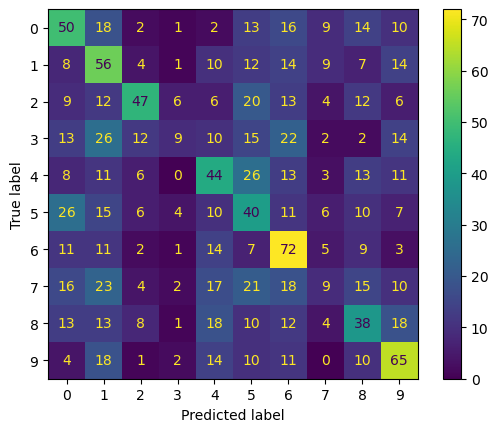

In [234]:
disp = ConfusionMatrixDisplay( confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1)),
                               display_labels=np.sort(np.unique(labels)) )
_ = disp.plot()

In [255]:
def top_n_accuracy_score(y, preds, n) :
    scores = []
    for j in range(preds.shape[0]) :
        score = 1 if y[j,:].argmax() in preds[j,:].argsort()[-n:] else 0
        
        scores.append( score )
            
    return sum(scores) / len(scores)

In [271]:
preds = trained_opt_model['model'].predict(X_test, verbose=0)

TOP_N = 3
within = top_n_accuracy_score(y_test, preds, TOP_N)

In [272]:
print('Within Top N Accuracy (Test Data): {:.2f}'.format(within))

Within Top N Accuracy (Test Data): 0.60
